In [19]:
%pip install wandb
%pip install matplotlib
%pip install numpy
%pip install tqdm
%matplotlib inline
%pip install pygame
%pip install gymnasium==0.29.1

In [3]:
#@title Imports
from collections import defaultdict #for accessing keys which are not present in dictionary
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import gymnasium as gym
import sys
import random
from matplotlib.patches import Patch

In [12]:
class BlackJack_TD_Agent:
    def __init__(
        self,
        epsilon:float,
        learning_rate:float,
        initial_epsilon:float,
        epsilon_decay:float,
        final_epsilon:float,
        discount_factor:float = 0.95,
        env = gym.make('Blackjack-v1',sab=False, natural=True, render_mode='rgb_array')
        ):
        #initialize the agent's parameters with empty state-action value (q_values),
        #a learning rate, an initial epsilon, an epsilon decay, a final epsilon and a discount factor
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.epsilon = epsilon #epsilon value
        self.lr = learning_rate #learning rate
        self.initial_epsilon = initial_epsilon #initial value of epsilon
        self.epsilon_decay = epsilon_decay #epsilon decay factor
        self.final_epsilon = final_epsilon #minimum value of epsilon
        self.discount_factor = discount_factor #gamma
        self.env = env #environment

        self.training_error = [] #list to store the training error at each episode

    def get_action(self, obs:tuple[int, int, bool])->int:
        #epsilon-greedy policy, returns the action with the highest q-value
        # for the given observation with probability 1-epsilon, this ensures exploration
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample() #explore
        else:
            return np.argmax(self.q_values[obs]) #exploit


    def update(
        self, obs:tuple[int, int, bool],
        action:int,
        reward:float,
        next_obs:tuple[int, int, bool],
        terminated:bool
        )->None:
        #update the q-values using the q-learning update rule
        #and the agent's learning rate and discount factor

        # if the episode is terminated, the future q-value is 0 (no future rewards) if its not terminated, we compute the future q-value
        future_q_value = 0 if terminated else np.max(self.q_values[next_obs])

        temporal_difference = (
            #compute the temporal difference (TD) error
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
            )

        self.q_values[obs][action] = (
            #update the q-value for the given observation and action
            self.q_values[obs][action] + self.lr * temporal_difference
            )

        #append the TD error to the training error list
        self.training_error.append(temporal_difference)

    def decay_epsilon(self)->None:
        #decay the epsilon value
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.final_epsilon)





In [13]:
from collections import deque
from gymnasium.wrappers import RecordEpisodeStatistics
from IPython.display import clear_output
import wandb
import pygame
from numpy import random

# Initialize wandb
#wandb.init(project="blackjack_TD", entity="ai42")
pygame.init()

#defining the hyperparameters
learning_rate = 0.01
n_episodes = 100000
initial_epsilon = 1.0
epsilon_decay = initial_epsilon / (n_episodes/2)
final_epsilon = 0.1
discount_factor = 0.95

#load the environment
env = gym.make('Blackjack-v1',sab=False, natural=True, render_mode='rgb_array') #We are not folllowing the default sutton and barto book settings, which are sab=True, natural=False, render_mode='human'

#initialize the agent
agent = BlackJack_TD_Agent(
    epsilon=initial_epsilon,
    learning_rate=learning_rate,
    initial_epsilon=initial_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount_factor,
    env=env
)

wins = 0.0
losses = 0.0
draws = 0.0
naturals = 0.0

# Only apply the wrapper once
if not isinstance(env, gym.wrappers.RecordEpisodeStatistics):
    # RecordEpisodeStatistics is a wrapper that keeps track of the rewards obtained in the last n episodes
    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    terminated, truncated = False, False
    clear_output()
    step = 0
    episode_rewards = 0  # Initialize total rewards for the episode

    #play one episode
    while not terminated and not truncated:
        action = agent.get_action(obs) #get the action
        next_obs, reward, terminated, truncated, info = env.step(action) #take the action and observe the results
        agent.update(obs, action, reward, terminated, next_obs) #update the q-values

        frame = env.render()
        step += 1
        episode_rewards += reward  # Accumulate rewards

        # Plot frame (frames are logged to wandb, they won't appear in the output of the cell)
        plt.imshow(frame)
        plt.axis('off')
        plt.title(f"Episode: {episode} - Step: {step} - Action Taken: {action} - Reward: {reward} - Terminated: {terminated}")

        plt.savefig('frame.png')
        plt.close()

        # Log the frame and rewards to wandb
        '''wandb.log({
            "episode": episode,
            "step": step,
            "frame": wandb.Image('frame.png'),
            "reward": reward,
            "cumulative_reward": episode_rewards
        })'''

        obs = next_obs #update the observation

    agent.decay_epsilon() #decay the epsilon value

    if reward == 1 or reward == 1.5:
        wins += 1
    elif reward == -1:
        losses += 1
    elif reward == 0:
        draws += 1
    if reward == 1.5:
        naturals += 1

env.close()

# Let´s log general statistics of the training
#wandb.log({"Win_rate": wins / n_episodes, "Loss_rate": losses / n_episodes, "Draw_rate": draws / n_episodes, "Natural_win_rate": naturals / n_episodes}) # Log the episode statistics to wandb


100%|██████████| 1000/1000 [04:47<00:00,  3.48it/s]


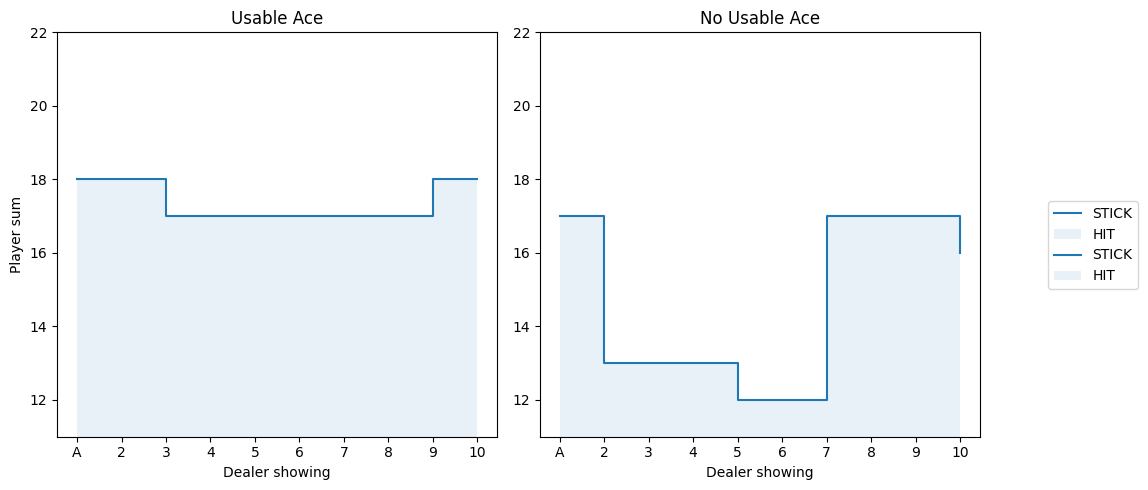

In [9]:
# Function to plot the policy of the agent
def plot_policy(agent):
    # Define the colormap using black for 'hit' and white for 'stick'
    cmap = plt.cm.coolwarm
    bounds = [0, 0.5, 1]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

    # Create subplots
    fig, ax = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1]}, sharey=True)

    # Plot the policy for usable ace and no usable ace
    for subplot, usable_ace in zip(ax, [True, False]):
        policy = np.zeros((10, 10))  # 10x10 for player's sum 12-21 and dealer's card A-10
        for player_sum in range(12, 22):
            for dealer_card in range(1, 11):
                state = (player_sum, dealer_card, usable_ace)
                action = np.argmax(agent.q_values[state])  # Get the best action (0 for stick, 1 for hit)
                policy[player_sum-12, dealer_card-1] = action

        # Plotting the policy with correct axes limits and aspect ratio
        subplot.step(range(1, 11), [18 if usable_ace else 17]*10, where='post', label='STICK')
        subplot.fill_between(range(1, 11), 11, [18 if usable_ace else 17]*10, step='post', alpha=0.1, label='HIT')
        subplot.set_ylim(11, 22)
        subplot.set_ylabel('Player sum')
        subplot.set_xlabel('Dealer showing')
        title = 'Usable Ace' if usable_ace else 'No Usable Ace'
        subplot.set_title(title)
        subplot.set_xticks(range(1, 11))
        subplot.set_yticks(range(11, 22))

    # Fine-tune and show the plot with legend outside the plot
    fig.tight_layout()
    legend = fig.legend(loc='center right', bbox_to_anchor=(1.15, 0.5))
    plt.setp(legend.get_texts(), color='black')

    plt.show()

plot_policy(agent)